## This is the second practical task of Sirius summer school "Applying AI for Med image analysis". 
Practical tasks take form of jupyter notebook with example code in the begging and some tasks in the end. Please, provide your solution in form of python code. Read hints, google a lot, don't hesitate to ask us directyl and most importatly - 
<span style="color:blue">have fun</span>.


**Topic**: Deep learning segmentation 

**To submit**: New version of the notebook, with your code. 

Loading dataset for segmentation is a bit different from simple classification. Below is full dataset class, which loads image and corresponding segmentation mask. 

In [ ]:
#to read mask files
!pip install imageio 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import imageio
import torch
from torch.utils.data import Dataset,DataLoader
import os 
import matplotlib.pyplot as plt
import albumentations as albu
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split

class LungSegmentationDataset(Dataset):
    def __init__(self,image_list,augmentations=None,transformations=None):
        self.path = "/content/drive/My Drive/Sirius 2020/data/Lung images from Bram"
        self.images = image_list
        self.augmentations = augmentations
        self.transformations = transformations
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        filename = self.images[index]
        image = imageio.imread(os.path.join(self.path,"Images/"+filename))
        mask_name = filename.split(".")[0]+".gif"
        left_lung = imageio.imread(os.path.join(self.path,"scratch/masks/left lung/"+mask_name))
        right_lung = imageio.imread(os.path.join(self.path,"scratch/masks/right lung/"+mask_name))
        lungs = left_lung + right_lung
        result = {"image":image,"mask":lungs}
        
        if self.transformations:
            result = self.transformations(**result)
            
        if self.augmentations:
            result = self.augmentations(**result)
        return result
  

In [ ]:
images = os.listdir("/content/drive/My Drive/Sirius 2020/data/Lung images from Bram/Images")
transorms = Compose([albu.augmentations.transforms.Resize(224,224),ToTensor()])
#HINT: to combine augmentations or transforms use albumentations.core.composition.Compose
train,test = train_test_split(images,test_size=0.2)

train = LungSegmentationDataset(train,transformations=transorms)
test = LungSegmentationDataset(test,transformations=transorms) #do not apply augmentations to test set

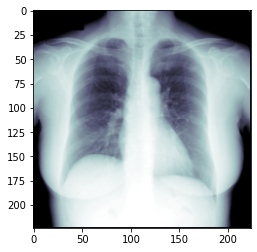

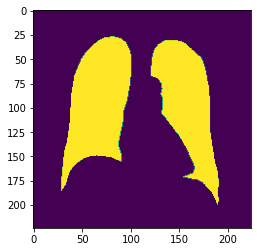

In [ ]:
#Visualization
sample = train[0]
plt.imshow(sample['image'][0],cmap="bone")
plt.show()
plt.imshow(sample['mask'][0])

In [ ]:
!pip install segmentation-models-pytorch

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


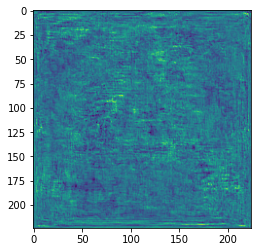

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet('resnet34', classes=1)

print(sample['image'].shape)
print(sample['image'].unsqueeze(0).shape)
res = model(sample['image'].unsqueeze(0))
plt.imshow(res.detach().numpy()[0,0])

In [ ]:
from torch import optim
train_loader = DataLoader(train,batch_size=10)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [ ]:
for sample in train_loader:
   image, label = sample['image'],sample['mask']
   prediction = model(image)
   loss = criterion(label,prediction)
   loss.backward()
   optimizer.step()

## **Task 2:**
- Your task is to create training loop and train some model to output segmentation. We won't judge model quality, just the corectness of training loop. To get some inspiration:
- Given: Dataset class for lung segmentation
- Do: Create training loop, which will fit **any** segmentation model with proper loss function. 


- https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/
- https://medium.com/analytics-vidhya/pytorch-implementation-of-semantic-segmentation-for-single-class-from-scratch-81f96643c98c

In [ ]:
from torch.optim import SGD, Adam, lr_scheduler

train_loader = DataLoader(train, batch_size=10, shuffle=True)
test_loader = DataLoader(test, batch_size=10, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet('resnet34', classes=1)
model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=3, verbose=True)

In [ ]:
epochs = 15
for epoch in range(epochs):
    model.train()
    epochLoss = 0
    train_loss = 0
    test_loss = 0
    for sample in train_loader:
        data, target = sample['image'], sample['mask']
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    # del data, target, sample
    with torch.no_grad():
        for sample in test_loader:
            data, target = sample['image'], sample['mask']
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    # dice_score = dice_score/len(valid_loader.dataset)
    print("Epoch = {:-3}; Train loss = {:.4f}; Test loss = {:.4f}".format(epoch,train_loss,test_loss))

Epoch =   0; Train loss = 0.2895; Test loss = 0.3432
Epoch =   1; Train loss = 0.1162; Test loss = 0.1153
Epoch =   2; Train loss = 0.0758; Test loss = 0.0682
Epoch =   3; Train loss = 0.0568; Test loss = 0.0569
Epoch =   4; Train loss = 0.0485; Test loss = 0.0508
Epoch =   5; Train loss = 0.0427; Test loss = 0.0446
Epoch =   6; Train loss = 0.0386; Test loss = 0.0412
Epoch =   7; Train loss = 0.0346; Test loss = 0.0401
Epoch =   8; Train loss = 0.0308; Test loss = 0.0392
Epoch =   9; Train loss = 0.0282; Test loss = 0.0366
Epoch =  10; Train loss = 0.0271; Test loss = 0.0364
Epoch =  11; Train loss = 0.0270; Test loss = 0.0377
Epoch =  12; Train loss = 0.0251; Test loss = 0.0346
Epoch =  13; Train loss = 0.0242; Test loss = 0.0362
Epoch =  14; Train loss = 0.0236; Test loss = 0.0420
